<h1 style="text-align: center;" >HR Utilization tool</h1>                                          

<p align="center">
<img width="650" src="https://media3.giphy.com/media/xTiTnpVDp86JbFCdzi/200w.webp?cid=ecf05e47rzwdkrwj6xwv2nc3gmqraj43bax3c66d5dvkgz1r&rid=200w.webp&ct=g" alt="Assignment 2" title="" />
    
</p>
    

# Table of Content: <a class="car" id="table-of-content"></a>
* [1. Problem Background and Motivation](#problem-background)<br>
* [2. Libraries ](#import-packages)<br>
 * [2.1 User Defined Functions](#udf)<br>    
* [3. Data Preparation](#data-prep)<br>
* [4. Machine Learning Model Implementation](#ml-model)<br>
* [5. Deployment of Model](#model-deployment)<br><br>

[Conclusion](#Conclusion)

# 1. Problem Background and Motivation <a class="car" id="problem-background"></a>

### Resource Allocator for XYZ Company

>**What is the problem in Question?**<br>
>  By stating whether a work has been done or not, we hope to utilize all of the company's resources to the fullest extent possible. To forecast work completion, we'll use staff experience and training.<br><br>

>**Who will be our stakeholders?**<br>
> * HR department, in order for them to assign teams more effectively .<br>
> * Clients—so they can keep track of task fulfillment and simplify the procedure.<br><br>

>**Why is it important?**<br>
> By using this technology, the HR department can boost employee productivity overall and make the best use of its resources.
Additionally, this will avoid any unnecessary labour and may ultimately aid the business in boosting revenues. Additionally, it increases the clients' trust in the business by providing transparency.




# 2. Libraries Used <a class="car" id="import-packages"></a>
* [Go to Top](#table-of-content)

In [1]:
######################################
# Importing various python libraries
#  1. Pandas is a data analysis and manipulation library. We are using it to read the datasets
#  2. sklearn is machine learning library of python. we need it for running the prediction model.
#  3. Multiple visualization libraries are given below
######################################
import pandas as pd
import numpy as np

# Graphics
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_auc_score,roc_curve,plot_roc_curve

pd.set_option('display.max_columns', None)

pd.options.display.float_format = '{:,.2f}'.format

## 2.1 User Defined Functions <a class="car" id="udf"></a>
* [Go to Top](#table-of-content)

In [2]:
#########################
#Additional user defined functions 
#########################
'''
In this Function we are using inbuilt libraries to create a datafraem with all relevant performance measures
'''
def class_perf_measures(model,y_test,probab_threshold):
    # Create empty lists to store metric values created within loop
    TP = []
    TN = []
    FP = []
    FN = []
    recall = []
    precision = []
    F1 = []
    Accuracy = []
    AUC_ROC =[]    

    # Start loop
    for i in probab_threshold:

        # Create class assignments given threshold value
        y_test_pred_class = (model.predict_proba(X_test)[:,1] >= i).astype(int)

        # Append lists with metric values
        TP.append(metrics.confusion_matrix(y_test, y_test_pred_class)[1,1])
        TN.append(metrics.confusion_matrix(y_test, y_test_pred_class)[0,0])
        FP.append(metrics.confusion_matrix(y_test, y_test_pred_class)[0,1])
        FN.append(metrics.confusion_matrix(y_test, y_test_pred_class)[1,0])
        recall.append(metrics.recall_score(y_test, y_test_pred_class).round(3))
        precision.append(metrics.precision_score(y_test, y_test_pred_class,zero_division=0).round(3))
        F1.append(metrics.f1_score(y_test, y_test_pred_class).round(2))
        Accuracy.append(metrics.accuracy_score(y_test, y_test_pred_class).round(2))
        AUC_ROC.append(metrics.roc_auc_score(y_test, y_test_pred_class))

    # Create dataframe
    result = pd.DataFrame({"threshold":threshold,
                           "TP":TP,
                           "TN":TN,
                           "FP":FP,
                           "FN":FN,
                           "Precision":precision,
                           "Recall":recall,
                           "f1":F1,
                           "AUC_ROC":AUC_ROC,
                           "Accuracy": Accuracy
                          })

    # Let's look at our dataframe
    return result

def data_stats(df,feature_list):
    '''
    This function we are calculating basic stats for all numerical columns. 
    To indicate outlier presence we are chcking if std/mean is greater than 1.5. Also if skewness of these columns
    are outside +-3 range
    '''
    temp =  df[feature_list].describe().round(2).T
    temp['median'] = df[feature_list].median().round(2)
    temp['outlier_presence'] = np.where((temp['std']/temp['mean']>1.5)| (df[feature_list].skew(axis = 0)>3) |(df[feature_list].skew(axis = 0)<-3),'True','False')
    return temp







# 3. Data Prep <a class="car" id="data-prep"></a>
* [3.1. Data Ingestion](#data-ingest)<br>
* [3.2. Remove Duplicates/Null values](#null-values)<br>
* [3.3. Feature Selection](#numfeature-selection)<br>
 * [3.3.1 Dealing with Outliers](#outlier-detection)<br>
 * [3.3.2 Check correlation](#correlations)<br>

* [3.4. Dealing with Categorical data](#categorical-data)<br>
 * [3.4.1 Reducing categorical data](#red-categorical-data)<br>
* [3.5. Multivariate Analysis](#mul-analysis)<br>
* [3.6. Feature Transformation and Finalization](#feature-transform)<br>
* [3.7. Splitting the data](#data-split)
* [3.8 Data Normalization](#normalization)




<br><br>
* [Go to Top](#table-of-content)

## 3.1 Data Ingestion <a class="car" id="data-ingest"></a>
* [Go to Data Prep](#data-prep)

In [3]:
df = pd.read_csv("SystemAdministrators.csv")

# df.tail()

# df.dtypes

> **Initial Evaluation**<br>

> task completed is our target.<br>

| **Column name**   | **Data type**  | **Description**               | **Comment (if any)**                          |   |   |
|-------------------|-----------|---------------------------|-------------------------------------------|---|---|
| task_completed    | int64     | This indicates if a task is completed or not    |  This is our target                                         |   |   |
| employee_experience             | float64    |experience of employee                 |                                           |   |   |
| training_level4              | int64     | training level certified by the company    |  |   |   |
| training_level6  | int64    | training level certified by the company                |                                           |   |   |
| training_level8         | int64   | training level certified by the company |  |   |   |


## 3.2 Remove Duplicates/Null values <a class="car" id="null-values"></a>
* [Go to Data Prep](#data-prep)

In [4]:
######################################
# Removing duplicates
######################################
cnt =df.shape[0]
print("Number of records before removing duplicates: "+str(cnt))

df.drop_duplicates(inplace =True)

print("Number of records after removing duplicates: "+str(df.shape[0]))
print("Duplicate records in the dataset: "+str(cnt - df.shape[0]))

Number of records before removing duplicates: 75
Number of records after removing duplicates: 64
Duplicate records in the dataset: 11


**Note**: No Duplicates. Data is clean.

In [5]:
######################################
# Removing Null values for our model to work
######################################
#This indicated sum of null values from all columns
df.isnull().sum()

task_completed         0
employee_experience    0
training_level4        0
training_level6        0
training_level8        0
dtype: int64

>**Decision:**
> * No Null values


## 3.3 Numerical Feature Selection <a class="car" id="numfeature-selection"></a>
* [Go to Data Prep](#data-prep)

In [6]:
######################################
# numeric features
######################################

numerical_features = ['employee_experience']
stats = data_stats(df,numerical_features)
display(stats)


,count,mean,std,min,25%,50%,75%,max,median,outlier_presence
employee_experience,64.00,7.02,2.38,2.70,5.28,6.65,8.30,13.70,6.65,False


> **Numerical Feature Stats**<br>

> Outlier Presence is calculated from ratio of standard deviation to mean and skewness in the data.<br>

> **Outcome:**<br>
> No Outlier detected. 








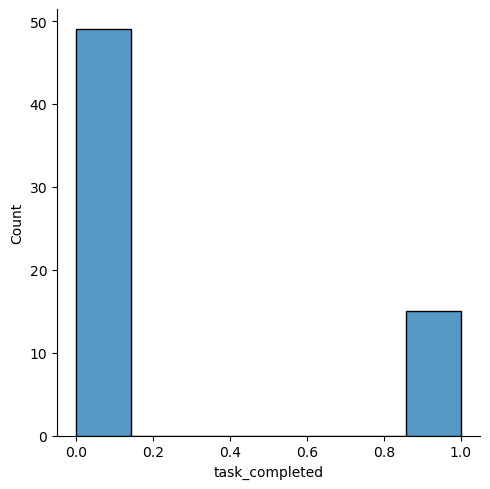

In [7]:
######################################
# Plotting a histogram of our target variable MSRP
######################################

sns.displot(df['task_completed'])

plt.show()

> **Observation:**<br>
> Since there are only 2 classes for our target, this makes sense.


### 3.3.1 Dealing with Outliers <a class="car" id="outlier-detection"></a>
* [Go to Data Prep](#data-prep)

> **Action Items**<br>
> Not Required

## 3.4 Categorical data <a class="car" id="categorical-data"></a>
* [Go to Data Prep](#data-prep)

> **categorical variables in use:**<br>
Data is already cleaned and we have isolated the required categorical variables i.e training_level4, training_level6,	training_level8<br><br>




## 3.5 Multivariate Analysis <a class="car" id="mul-analysis"></a>
* [Go to Data Prep](#data-prep)

### Multivariate Analysis outcome:<br><Br>

> Not Required





## 3.5 Feature Transformation <a class="car" id="feature-transform"></a><br>

> **Objective:** <br>
> Not Required


* [Go to Data Prep](#data-prep)

## 3.6 Splitting Data <a class="car" id="data-split"></a><br>
> **Creating a test/train split**<br>
* [Go to Data Prep](#data-prep)

In [8]:
predictors =['employee_experience','training_level4','training_level6','training_level8']

target = ['task_completed']

X = df[predictors]
y = df[target]

# Split data
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.3,random_state=2)

## 3.7 Data Normalization <a class="car" id="normalization"></a><br>
> **The goal of normalization is to change the values of numeric columns in the dataset to use a common scale, without distorting differences in the ranges of values or losing information**<br>
> We want to use the summary stats(std dev. and mean) from training data to normalize both training and testing data. 
* [Go to Data Prep](#data-prep)

In [9]:
#We are going to use the Z score to normalize data
means = X_train.mean()
std = X_train.std()

X_train = (X_train - means)/std
X_test = (X_test - means)/std

# 4. Machine Learning Model Implementation<a class="car" id="ml-model"></a>
> * [KNN Model](#first-model)
> * [Logistic Regression Model](#second-model)


-


<br><br>
* [Go to Top](#table-of-content)

> **KNN Model** <a class="car" id="first-model"></a>
<br>
> Objectives:<br>
> * Run a KNN model for different values of K and select a best model based on accuracy.
> * Compare with LR model for different metrics to finalise a model.

In [10]:
K_values = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]
probab_threshold = 0.5
results = []

for i in K_values:
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train.values.ravel())
#     print(knn.predict_proba(X_test))
    y_prediction = (knn.predict_proba(X_test)[:,1]>= probab_threshold ).astype(int)
    
    results.append({'k':i,
                   'Accuracy': metrics.accuracy_score(y_test,y_prediction)})
    
output = pd.DataFrame(results)

output

,k,Accuracy
0,1,0.70
1,3,0.85
2,5,0.80
3,7,0.75
4,9,0.75
5,11,0.75
6,13,0.75
7,15,0.75
8,17,0.75
9,19,0.75


**Decision**: Using K = 5 since it is one of the k values with high accuracy

In [11]:
Model1 = KNeighborsClassifier(n_neighbors=5)
Model1.fit(X_train,y_train.values.ravel())
# threshold = [0.2,0.4,0.6]
threshold = np.arange(0,1.1,0.1).tolist()
result = class_perf_measures(Model1,y_test,threshold)
result


,threshold,TP,TN,FP,FN,Precision,Recall,f1,AUC_ROC,Accuracy
0,0.00,5,0,15,0,0.25,1.00,0.40,0.50,0.25
1,0.10,5,6,9,0,0.36,1.00,0.53,0.70,0.55
2,0.20,5,6,9,0,0.36,1.00,0.53,0.70,0.55
3,0.30,4,12,3,1,0.57,0.80,0.67,0.80,0.80
4,0.40,4,12,3,1,0.57,0.80,0.67,0.80,0.80
5,0.50,2,14,1,3,0.67,0.40,0.50,0.67,0.80
6,0.60,0,15,0,5,0.00,0.00,0.00,0.50,0.75
7,0.70,0,15,0,5,0.00,0.00,0.00,0.50,0.75
8,0.80,0,15,0,5,0.00,0.00,0.00,0.50,0.75
9,0.90,0,15,0,5,0.00,0.00,0.00,0.50,0.75


> **LR Model** <a class="car" id="second-model"></a>
<br>
> Objectives:<br>
>  1. Run a LR model and evaluate different performance measures. <br>
>  2. compare various metrics to knn and choose a winning model

In [12]:

lr_model = LogisticRegression()
lr_model.fit(X_train,y_train.values.ravel())

y_train_pred_class_LR = lr_model.predict(X_train)
y_test_pred_class_LR = lr_model.predict(X_test)

print("Accuracy score is ",metrics.accuracy_score(y_test,y_test_pred_class_LR).round(2))



Accuracy score is  0.85


**Note** : to calculate a winning model, I will be using AUC score.

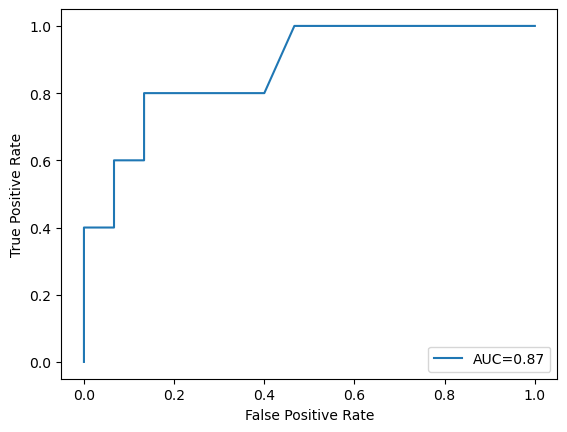

In [13]:
y_pred_Lr = lr_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_Lr)
auc1 = metrics.roc_auc_score(y_test, y_pred_Lr).round(2)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc1))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.savefig('LR_ROC_p1.png')
plt.show()

plt.close()

KNN ROC curve


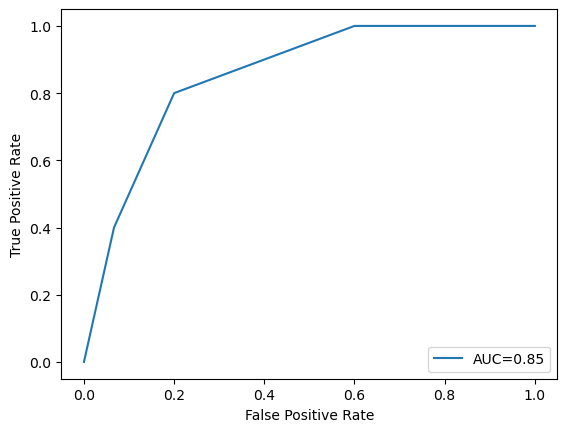

In [14]:
print('KNN ROC curve')
y_pred_proba_KNN = Model1.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba_KNN)
auc2 = metrics.roc_auc_score(y_test, y_pred_proba_KNN).round(2)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc2))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.savefig('KNN_ROC_p1.png')
plt.show()
plt.close()
# plt.savefig('KNN_ROC.png')

> **Final Model Selection**<br><br>
> LR model has high AUC score.ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1. By analogy, the Higher the AUC, the better the model is at distinguishing between task completed and task not completed.<br><br>
 Therefore, I will be using LR model for further evaluation.<br>
> Some other evaluation measures for classification are:
> * Classification accuracy.
> * Confusion matrix.
> * Precision and recall.
> * F1 score.
> * Sensitivity and specificity.
> * ROC curve and AUC.

In [15]:
class_perf_measures(lr_model,y_test,threshold)

,threshold,TP,TN,FP,FN,Precision,Recall,f1,AUC_ROC,Accuracy
0,0.00,5,0,15,0,0.25,1.00,0.40,0.50,0.25
1,0.10,5,8,7,0,0.42,1.00,0.59,0.77,0.65
2,0.20,4,13,2,1,0.67,0.80,0.73,0.83,0.85
3,0.30,3,13,2,2,0.60,0.60,0.60,0.73,0.80
4,0.40,3,14,1,2,0.75,0.60,0.67,0.77,0.85
5,0.50,2,15,0,3,1.00,0.40,0.57,0.70,0.85
6,0.60,2,15,0,3,1.00,0.40,0.57,0.70,0.85
7,0.70,0,15,0,5,0.00,0.00,0.00,0.50,0.75
8,0.80,0,15,0,5,0.00,0.00,0.00,0.50,0.75
9,0.90,0,15,0,5,0.00,0.00,0.00,0.50,0.75


### Compare Different Thresholds <br>
>  Remember that our objective is to determine if our model has marked the task completed or not based on employee experience and his training experience.<br>


> We will be checking for precision(TP/(TP+FP)) to calculate our ideal threshold.<br>

> 1. **Threshold value 0.1** <br>
>   * **False Positives** : Given the low threshold value, many positive predictions can be made. There will also be a great deal of false positives. We can see from the table that we have 7 false positives, which results in a precision of 0.42, which is too low and shows that our model will make many false predictions. This makes sense because we are stating that if the calculated probability is as low as 10%, we can declare the outcome to be true.
>   * **False Negatives** : For negative outcome the probabilty has to be atleast 0.9 which is very high. It means if the model is not absolute certain it will not give out a negative outcome. The false Negative value come out to be 0 for this threhold and recall is 1.<br>

>False positives, in my opinion, can have serious effects on the business model since they can make stakeholders lose interest in the model if it indicates that a task is complete but is actually still unfinished. It may also result in significant losses and delays in finishing the task.<br>

> 2. **Threshold value 0.6** <br>
>   * **False Positives** : Given this threshold value, the probablity is very close to the default probablity 0.5. For this level, we are only receiving 3 false negatives and 0 false positives.
>   * **False Negatives** : The false negative value will be 3 means we are indicating that a dtask is not finished even though it is.
>   * As was previously said, our business model demands that false positives may have negative consequences. This is superior to our previous cutoff point of 0.2. Additionally, the accuracy is 85%, which is really good. <br>



> 3. **Threshold value 0.8** <br>
>  * This threshold value is really high. As a result, our model will typically forecast unfavorable results. As we can see from the table, both **TP and FP** have 0 values (True positive and false positive). showing that there are no records for which we marked the data finished.
>  *  Although this resolves our false positive problem, it also decreases accuracy. Additionally, we are seeing an increase in false negative data, which suggests that our model is incorrectly categorizing completed tasks as unfinished.


**I will either we using 0.6 or 0.5 which is also the default probablity as threshold value for our model**

# 5. Deployment of Model <a class="car" id="model-deployment"></a>

* [Go to Top](#table-of-content)

In [16]:
import pickle
pickle_out = open('classifier1_sys_adm', mode='wb')
pickle.dump([lr_model,knn,means.to_list(),std.to_list()], pickle_out)

pickle_out.close()


In [17]:
%%writefile system_administrator_app.py
import streamlit as st
import pickle
import numpy as np

pickle_in = open('classifier1_sys_adm', 'rb')
pkl_in = pickle.load(pickle_in)

lr_model = pkl_in[0] 
knn = pkl_in[1]
means = pkl_in[2]
std = pkl_in[3]

# pickle_in2 = open('classifier2', 'rb')
# knn = pickle.load(pickle_in2)


@st.cache()

# Define the function which will make the prediction using data
# inputs from users
def prediction(input_list, prediction_probability, model_type ='LR'):
    # Make predictions
    if model_type =='LR':
        prediction = (lr_model.predict_proba([input_list])[::,1]>= prediction_probability ).astype(int)
    elif model_type =='KNN':
        prediction = (knn.predict_proba([input_list])[::,1]>= prediction_probability ).astype(int)
    
    if prediction == 0:
        pred = 'Task is incomplete'
    else:
        pred = ' Congrats! This task is already completed'
    return pred
def main():
    st.markdown("<h1 style='text-align: center; color: red;'>HR Task Indicator</h1>", unsafe_allow_html=True)

    
    # Create input fields
    employee_experience = st.number_input("Experience of employee(0-20 yrs)",
                                  min_value=0,
                                  max_value=20,
                                  value=2,
                                  step=1,
                                 )
    training_level4 = st.number_input("Select training level(4) (0-1)",
                              min_value=0,
                              max_value=1,
                              value=1,
                              step=1
                             )

    training_level6 = st.number_input("Select training level(6) (0-1)",
                              min_value=0,
                              max_value=1,
                              value=1,
                              step=1
                             )
    training_level8 = st.number_input("Select training level(8)",
                          min_value=0,
                              max_value=1,
                              value=1,
                              step=1
                         )
    model_type = st.sidebar.selectbox("Model type", ['KNN','LR'])
    prediction_probability = [st.sidebar.slider("Probablity Threshold",0.0, 1.0, 0.3, 0.01)]
    
    
    #scaling data with test stats used for training
    
    
    input_data = [employee_experience,training_level4,training_level6,training_level8]
    input_list1 = np.divide(np.subtract(input_data,means),std).tolist()
    
    
    
    result = ""
#     with st.sidebar:
#         result = prediction(employee_experience,training_level4,training_level6,training_level8, prediction_probability, model_type)
#         st.success(result)
        

    
    # When 'Predict' is clicked, make the prediction and store it
    if st.button("Predict"):
        result = prediction(input_list1, prediction_probability, model_type)
        if result =='Congrats! This task is already completed':
            st.balloons()
        st.success(result)
        
    if st.button('Show ROC curve'):
        if model_type =='KNN':
            st.image('KNN_ROC_p1.png',caption='KNN ROC image')
        elif model_type =='LR':
            st.image('LR_ROC_p1.png',caption='LR ROC image')
       
if __name__=='__main__':
    main()

Writing system_administrator_app.py


In [18]:
!streamlit run system_administrator_app.py

^C


# Conclusion <a class="car" id="Conclusion"></a>

> The model is fairly accurate and we can continue using default threshold for probability. We need more data to train our model so that it can be trained for fairly unpredicted data. Also we lack certain realistic parameters to train our model bbor real-time business application.




* [Go to Top](#table-of-content)